In [59]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import torch
from torch import nn, optim
from sklearn.model_selection import train_test_split
import tqdm
import copy

In [97]:
x = np.random.randn(10**5, 250)

In [98]:
x.shape

(100000, 250)

In [99]:
class NeuralNet(nn.Module):
    def __init__(self, input_shape: int):
        super().__init__()
        self.relu = nn.ReLU()
        self.hidden1 = nn.Linear(input_shape, 8)
        self.hidden2 = nn.Linear(8, 256)
        self.output = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.output(x))
        return x

In [100]:
X = x[:, 0:250]
y = x[:, -1].reshape(-1, 1)

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [102]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Model will run on {device}")

X_train = torch.tensor(X_train, dtype=torch.float).to(device)
X_test = torch.tensor(X_test, dtype=torch.float).to(device)
y_train = torch.tensor(y_train, dtype=torch.float).to(device)
y_test = torch.tensor(y_test, dtype=torch.float).to(device)

Model will run on cuda


In [103]:
model = NeuralNet(input_shape=X_train.shape[1]).to(device)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [104]:
n_epochs = 100
batch_size = 100
batch_start = torch.arange(0, len(X_train), batch_size)

best_mse = np.inf
best_weights = None
history = []

In [105]:
for epoch in range(n_epochs):
    model.train()
    with tqdm.tqdm(batch_start, unit='batch', mininterval=0, disable=False) as bar:
        bar.set_description(f'Epoch {epoch}')
        for start in bar:
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            
            bar.set_postfix(mse=float(loss))
            
    model.eval()
    y_pred = model(X_test)
    mse = float(loss_fn(y_pred, y_test))
    history.append(mse)
    if mse < best_mse:
        best_mse = mse
        best_weights = copy.deepcopy(model.state_dict())
        
model.load_state_dict(best_weights)

Epoch 8:  25%|███████████████▊                                                | 185/750 [00:00<00:02, 218.54batch/s, mse=1.03]

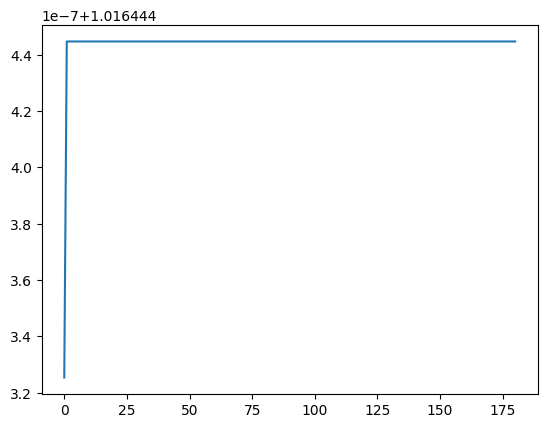

In [95]:
plt.plot(history)